# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [131]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [132]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [133]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-07-24 09:00:00+09:00,41657.980469,41740.710938,41554.179688,41719.230469,0,0.0,0.0
2025-07-24 09:15:00+09:00,41725.429688,41736.691406,41627.019531,41643.929688,0,0.0,0.0
2025-07-24 09:30:00+09:00,41636.730469,41730.531250,41611.699219,41730.531250,0,0.0,0.0
2025-07-24 09:45:00+09:00,41722.750000,41801.281250,41684.210938,41784.640625,0,0.0,0.0
2025-07-24 10:00:00+09:00,41795.429688,41860.011719,41780.519531,41850.429688,0,0.0,0.0
2025-07-24 10:15:00+09:00,41853.890625,41937.210938,41840.351562,41892.441406,0,0.0,0.0
2025-07-24 10:30:00+09:00,41893.621094,41957.531250,41885.601562,41927.558594,0,0.0,0.0
2025-07-24 10:45:00+09:00,41930.839844,41989.648438,41870.480469,41975.121094,0,0.0,0.0
2025-07-24 11:00:00+09:00,41977.089844,42004.921875,41945.921875,41972.511719,0,0.0,0.0


## 前日終値の取得

In [134]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(period="1d", interval="1d", start=str(dt_prev.date()))
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-07-23 00:00:00+09:00    41171.320312
Name: Close, dtype: float64

## ローソク足チャート（小さいサイズ）

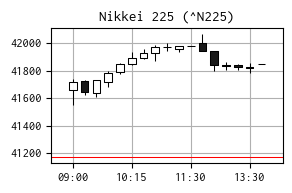

In [135]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()